In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
!pip install torch pandas scikit-learn transformers esm
!pip install torch torchvision
!pip install fair-esm
!pip install scikit-learn pandas

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.4/44.4 kB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 139.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 100.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 66.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 11.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 42.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 19.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 111.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 100.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

Using device: cuda
ec1 classes: ['1' '2' '3' '4' '5' '6' '7']
ec1 encoded shape: (275710,)
ec2 classes: ['1' '10' '11' '12' '13' '14' '15' '16' '17' '18' '2' '20' '21' '23' '3'
 '4' '5' '6' '7' '8' '9' '97' '98' '99']
ec2 encoded shape: (275710,)


Downloading: "https://dl.fbaipublicfiles.com/fair-esm/models/esm2_t33_650M_UR50D.pt" to /root/.cache/torch/hub/checkpoints/esm2_t33_650M_UR50D.pt
Downloading: "https://dl.fbaipublicfiles.com/fair-esm/regression/esm2_t33_650M_UR50D-contact-regression.pt" to /root/.cache/torch/hub/checkpoints/esm2_t33_650M_UR50D-contact-regression.pt
100%|██████████| 26673/26673 [51:38<00:00,  8.61it/s]


Epoch 1 | Train Loss: 2.1295 | Train F1: {'f1_ec1': 0.6565630159443273, 'f1_ec2': 0.33628998098145546, 'f1_mean': 0.4964264984628914}
Epoch 1 | Val F1: {'f1_ec1': 0.6991311011062532, 'f1_ec2': 0.5397495941282985, 'f1_mean': 0.6194403476172758}
Epoch 2 | Train Loss: 1.5563 | Train F1: {'f1_ec1': 0.7266628085069277, 'f1_ec2': 0.4586873276913588, 'f1_mean': 0.5926750680991433}
Epoch 2 | Val F1: {'f1_ec1': 0.758077759557483, 'f1_ec2': 0.5466960618964287, 'f1_mean': 0.6523869107269559}
Epoch 3 | Train Loss: 1.3863 | Train F1: {'f1_ec1': 0.7414451252212064, 'f1_ec2': 0.5048077984668956, 'f1_mean': 0.6231264618440511}
Epoch 3 | Val F1: {'f1_ec1': 0.7176872724514057, 'f1_ec2': 0.5541089293307748, 'f1_mean': 0.6358981008910902}
Epoch 4 | Train Loss: 1.2983 | Train F1: {'f1_ec1': 0.751907144209496, 'f1_ec2': 0.5322421903869895, 'f1_mean': 0.6420746672982427}
Epoch 4 | Val F1: {'f1_ec1': 0.7627470447109845, 'f1_ec2': 0.6015137696503151, 'f1_mean': 0.6821304071806498}
Epoch 5 | Train Loss: 1.2451 

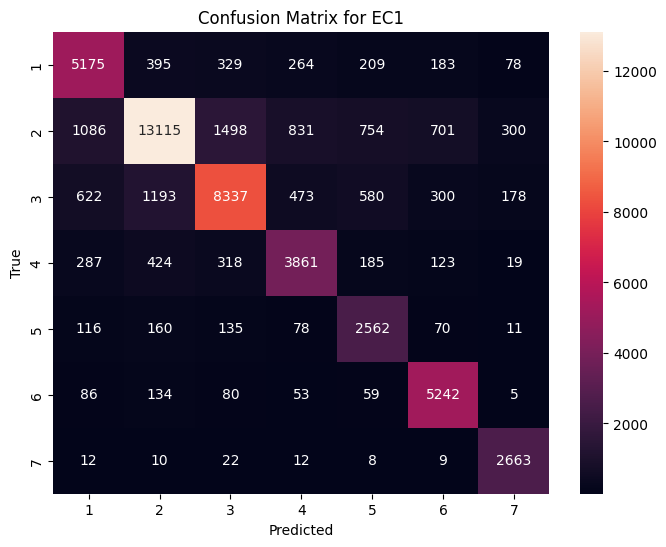

Predicted EC for new sequence: 3.2


In [ ]:
# 1. Imports and Data Loading
import pandas as pd
import ast
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import f1_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
import numpy as np
from tqdm import tqdm
import esm
import matplotlib.pyplot as plt
import seaborn as sns

# 2. Device Setup (A100)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# 3. Load Data
df = pd.read_csv("/content/drive/MyDrive/cleaned_train.csv")
df['ec_list'] = df['ec_list'].apply(lambda x: ast.literal_eval(x) if pd.notnull(x) else [])

# 4. Extract ec1 and ec2 from the first EC number in each list
def split_ec(ec):
    parts = str(ec).split('.')
    while len(parts) < 2:
        parts.append('-')
    return parts[:2]

def extract_levels(ec_list):
    if ec_list:
        return split_ec(ec_list[0])
    else:
        return ['-', '-']

ec_levels = pd.DataFrame(df['ec_list'].apply(extract_levels).tolist(), columns=['ec1', 'ec2'])

# 5. Encode ec1 and ec2
encoders = []
y_levels = []
for col in ['ec1', 'ec2']:
    le = LabelEncoder()
    y = le.fit_transform(ec_levels[col])
    encoders.append(le)
    y_levels.append(y)
    print(f"{col} classes:", le.classes_)
    print(f"{col} encoded shape:", y.shape)

y_ec1 = y_levels[0]
y_ec2 = y_levels[1]

# 6. Compute Class Weights (for imbalance)
ec1_weights = compute_class_weight('balanced', classes=np.unique(y_ec1), y=y_ec1)
ec2_weights = compute_class_weight('balanced', classes=np.unique(y_ec2), y=y_ec2)
ec1_weights = torch.tensor(ec1_weights, dtype=torch.float).to(device)
ec2_weights = torch.tensor(ec2_weights, dtype=torch.float).to(device)

# 7. Filter or Truncate Long Sequences
MAX_LEN = 1022  # ESM-2 safe max length for most configs
X = df['Sequence'].tolist()
filtered = [(seq, i) for i, seq in enumerate(X) if len(seq) <= MAX_LEN]
if not filtered:
    raise ValueError("No sequences under the max length threshold!")
X_filtered, idx_filtered = zip(*filtered)

# 8. Train/Validation Split
X_train, X_val, idx_train, idx_val = train_test_split(
    list(X_filtered), list(idx_filtered), test_size=0.2, random_state=42, stratify=[y_ec1[i] for i in idx_filtered]
)

# 9. ESM-2 Model Load (Smallest for demo; use larger for more accuracy)
esm_model, alphabet = esm.pretrained.esm2_t33_650M_UR50D()
batch_converter = alphabet.get_batch_converter()
esm_model = esm_model.to(device)
esm_model.eval()

# 10. Embedding Function
def embed_sequences(sequences, batch_size=2):
    all_embeddings = []
    with torch.no_grad():
        for i in tqdm(range(0, len(sequences), batch_size)):
            batch_seqs = [(str(idx), seq) for idx, seq in enumerate(sequences[i:i+batch_size])]
            batch_labels, batch_strs, batch_tokens = batch_converter(batch_seqs)
            batch_tokens = batch_tokens.to(device)
            try:
                results = esm_model(batch_tokens, repr_layers=[6])
            except RuntimeError as e:
                print(f"OOM at batch {i}: {e}")
                torch.cuda.empty_cache()
                continue
            token_representations = results["representations"][6]
            cls_representations = token_representations[:, 0, :].cpu()
            all_embeddings.append(cls_representations)
    return torch.cat(all_embeddings, dim=0)

# 11. Embed Train/Validation Sequences
X_emb_train = embed_sequences(X_train, batch_size=2)
X_emb_val = embed_sequences(X_val, batch_size=2)

y_ec1_train = torch.tensor([y_ec1[i] for i in idx_train], dtype=torch.long)
y_ec2_train = torch.tensor([y_ec2[i] for i in idx_train], dtype=torch.long)
y_ec1_val = torch.tensor([y_ec1[i] for i in idx_val], dtype=torch.long)
y_ec2_val = torch.tensor([y_ec2[i] for i in idx_val], dtype=torch.long)

# 12. Dataset and DataLoader
class ECDataset(Dataset):
    def __init__(self, embeddings, y_ec1, y_ec2):
        self.embeddings = embeddings
        self.y_ec1 = y_ec1
        self.y_ec2 = y_ec2

    def __len__(self):
        return len(self.embeddings)

    def __getitem__(self, idx):
        return (
            self.embeddings[idx],
            self.y_ec1[idx],
            self.y_ec2[idx]
        )

train_dataset = ECDataset(X_emb_train.float(), y_ec1_train, y_ec2_train)
val_dataset = ECDataset(X_emb_val.float(), y_ec1_val, y_ec2_val)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64)

# 13. Model Definition
class EC2Classifier(nn.Module):
    def __init__(self, emb_dim, n_ec1, n_ec2):
        super().__init__()
        self.head1 = nn.Linear(emb_dim, n_ec1)
        self.head2 = nn.Linear(emb_dim, n_ec2)
    def forward(self, x):
        return self.head1(x), self.head2(x)

n_ec1 = len(encoders[0].classes_)
n_ec2 = len(encoders[1].classes_)
model = EC2Classifier(X_emb_train.shape[1], n_ec1, n_ec2).to(device)

# 14. Loss and Metrics
def bcedigitloss(logits1, logits2, targets1, targets2):
    loss1 = F.cross_entropy(logits1, targets1, weight=ec1_weights)
    loss2 = F.cross_entropy(logits2, targets2, weight=ec2_weights)
    return loss1 + loss2

def f1_digits(preds1, preds2, targets1, targets2):
    f1_1 = f1_score(targets1.cpu(), preds1.cpu(), average='macro')
    f1_2 = f1_score(targets2.cpu(), preds2.cpu(), average='macro')
    return {'f1_ec1': f1_1, 'f1_ec2': f1_2, 'f1_mean': (f1_1 + f1_2) / 2}

# 15. Training Loop with Validation and Metrics
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
epochs = 10

for epoch in range(epochs):
    model.train()
    total_loss = 0
    all_preds1, all_preds2 = [], []
    all_targets1, all_targets2 = [], []
    for batch_X, batch_y1, batch_y2 in train_loader:
        batch_X = batch_X.to(device)
        batch_y1 = batch_y1.to(device)
        batch_y2 = batch_y2.to(device)
        optimizer.zero_grad()
        logits1, logits2 = model(batch_X)
        loss = bcedigitloss(logits1, logits2, batch_y1, batch_y2)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * batch_X.size(0)
        preds1 = logits1.argmax(dim=1)
        preds2 = logits2.argmax(dim=1)
        all_preds1.append(preds1.cpu())
        all_preds2.append(preds2.cpu())
        all_targets1.append(batch_y1.cpu())
        all_targets2.append(batch_y2.cpu())
    all_preds1 = torch.cat(all_preds1)
    all_preds2 = torch.cat(all_preds2)
    all_targets1 = torch.cat(all_targets1)
    all_targets2 = torch.cat(all_targets2)
    f1s_train = f1_digits(all_preds1, all_preds2, all_targets1, all_targets2)
    print(f"Epoch {epoch+1} | Train Loss: {total_loss / len(train_dataset):.4f} | Train F1: {f1s_train}")

    # Validation
    model.eval()
    val_preds1, val_preds2 = [], []
    val_targets1, val_targets2 = [], []
    with torch.no_grad():
        for batch_X, batch_y1, batch_y2 in val_loader:
            batch_X = batch_X.to(device)
            logits1, logits2 = model(batch_X)
            preds1 = logits1.argmax(dim=1)
            preds2 = logits2.argmax(dim=1)
            val_preds1.append(preds1.cpu())
            val_preds2.append(preds2.cpu())
            val_targets1.append(batch_y1)
            val_targets2.append(batch_y2)
    val_preds1 = torch.cat(val_preds1)
    val_preds2 = torch.cat(val_preds2)
    val_targets1 = torch.cat(val_targets1)
    val_targets2 = torch.cat(val_targets2)
    f1s_val = f1_digits(val_preds1, val_preds2, val_targets1, val_targets2)
    print(f"Epoch {epoch+1} | Val F1: {f1s_val}")

# 16. Confusion Matrix and Classification Report
print("\nClassification report for ec1:")
print(classification_report(val_targets1, val_preds1, target_names=encoders[0].classes_))
print("\nClassification report for ec2:")
print(classification_report(val_targets2, val_preds2, target_names=encoders[1].classes_))

# Plot confusion matrix for ec1
cm_ec1 = confusion_matrix(val_targets1, val_preds1)
plt.figure(figsize=(8,6))
sns.heatmap(cm_ec1, annot=True, fmt='d', xticklabels=encoders[0].classes_, yticklabels=encoders[0].classes_)
plt.title("Confusion Matrix for EC1")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

# 17. Save and Load Model
torch.save(model.state_dict(), "ec2_classifier.pt")
# To load:
# model.load_state_dict(torch.load("ec2_classifier.pt"))
# model.eval()

# 18. Inference Function for New Sequences (with chunking for long sequences)
def chunk_sequence(sequence, maxlen=1022, overlap=128):
    chunks = []
    i = 0
    while i < len(sequence):
        chunks.append(sequence[i:i+maxlen])
        if overlap > 0:
            i += maxlen - overlap
        else:
            i += maxlen
    return chunks

def embed_and_predict_full_sequence(sequence, model, encoders, batch_converter, esm_model, device):
    chunks = chunk_sequence(sequence, maxlen=1022, overlap=128)
    all_embs = []
    for chunk in chunks:
        with torch.no_grad():
            batch_seqs = [("0", chunk)]
            batch_labels, batch_strs, batch_tokens = batch_converter(batch_seqs)
            batch_tokens = batch_tokens.to(device)
            results = esm_model(batch_tokens, repr_layers=[6])
            token_representations = results["representations"][6]
            cls_rep = token_representations[:, 0, :].cpu()
            all_embs.append(cls_rep)
    X_emb = torch.mean(torch.stack(all_embs), dim=0)
    with torch.no_grad():
        logits1, logits2 = model(X_emb.to(device).float())
        preds1 = logits1.argmax(dim=1)
        preds2 = logits2.argmax(dim=1)
        decoded = decode_ec(preds1, preds2, encoders)
    return decoded[0]

def decode_ec(preds1, preds2, encoders):
    ec1 = encoders[0].inverse_transform(preds1.cpu().numpy())
    ec2 = encoders[1].inverse_transform(preds2.cpu().numpy())
    return [f"{a}.{b}" for a, b in zip(ec1, ec2)]

# Example inference:
new_sequence = "MYRKLAVISAFLATARAQSACTLQSETHPPLTWQKCSSGGTCTQQTGSVVIDANWRWTHATNSSTNCYDGNTWSSTLCPDNETCAKNCCLDGAAYASTYGVTTSGNSLSIGFVTQSAQKNVGARLYLMASDTTYQEFTLLGNEFSFDVDVSQLPCGLNGALYFVSMDADGGVSKYPTNTAGAKYGTGYCDSQCPRDLKFINGQANVEGWEPSSNNANTGIGGHGSCCSEMDIWEANSISEALTPHPCTTVGQEICEGDGCGGTYSDNRYGGTCDPDGCDWNPYRLGNTSFYGPGSSFTLDTTKKLTVVTQFETSGAINRYYVQNGVTFQQPNAELGSYSGNELNDDYCTAEEAEFGGSSFSDKGGLTQFKKATSGGMVLVMSLWDDYYANMLWLDSTYPTNETSSTPGAVRGSCSTSSGVPAQVESQSPNAKVTFSNIKFGPIGSTGNPSGGNPPGGNPPGTTTTRRPATTTGSSPGPTQSHYGQCGGIGYSGPTVCASGTTCQVLNPYYSQCL"
predicted_ec = embed_and_predict_full_sequence(
    new_sequence, model, encoders, batch_converter, esm_model, device
)
print("Predicted EC for new sequence:", predicted_ec)

In [6]:
from sklearn.metrics import f1_score, accuracy_score

print("\n=== EC1 Metrics ===")
print("Macro F1:", f1_score(val_targets1, val_preds1, average='macro'))
print("Micro F1:", f1_score(val_targets1, val_preds1, average='micro'))
print("Weighted F1:", f1_score(val_targets1, val_preds1, average='weighted'))
print("Accuracy:", accuracy_score(val_targets1, val_preds1))

print("\n=== EC2 Metrics ===")
print("Macro F1:", f1_score(val_targets2, val_preds2, average='macro'))
print("Micro F1:", f1_score(val_targets2, val_preds2, average='micro'))
print("Weighted F1:", f1_score(val_targets2, val_preds2, average='weighted'))
print("Accuracy:", accuracy_score(val_targets2, val_preds2))

macro_f1_mean = (f1_score(val_targets1, val_preds1, average='macro') + f1_score(val_targets2, val_preds2, average='macro')) / 2
micro_f1_mean = (f1_score(val_targets1, val_preds1, average='micro') + f1_score(val_targets2, val_preds2, average='micro')) / 2
weighted_f1_mean = (f1_score(val_targets1, val_preds1, average='weighted') + f1_score(val_targets2, val_preds2, average='weighted')) / 2
accuracy_mean = (accuracy_score(val_targets1, val_preds1) + accuracy_score(val_targets2, val_preds2)) / 2

print("\n=== Mean Metrics (EC1 & EC2) ===")
print("Mean Macro F1:", macro_f1_mean)
print("Mean Micro F1:", micro_f1_mean)
print("Mean Weighted F1:", weighted_f1_mean)
print("Mean Accuracy:", accuracy_mean)


=== EC1 Metrics ===
Macro F1: 0.7718581664183394
Micro F1: 0.7677383072452901
Weighted F1: 0.7677728557057286
Accuracy: 0.7677383072452901

=== EC2 Metrics ===
Macro F1: 0.6065912926727016
Micro F1: 0.6555815915268535
Weighted F1: 0.670219111371492
Accuracy: 0.6555815915268535

=== Mean Metrics (EC1 & EC2) ===
Mean Macro F1: 0.6892247295455205
Mean Micro F1: 0.7116599493860718
Mean Weighted F1: 0.7189959835386104
Mean Accuracy: 0.7116599493860718


In [8]:
from sklearn.metrics import f1_score

# For EC1
macro_f1_ec1 = f1_score(val_targets1, val_preds1, average='macro')
micro_f1_ec1 = f1_score(val_targets1, val_preds1, average='micro')
weighted_f1_ec1 = f1_score(val_targets1, val_preds1, average='weighted')

# For EC2
macro_f1_ec2 = f1_score(val_targets2, val_preds2, average='macro')
micro_f1_ec2 = f1_score(val_targets2, val_preds2, average='micro')
weighted_f1_ec2 = f1_score(val_targets2, val_preds2, average='weighted')

# (Optional) Mean across EC1 and EC2
mean_macro_f1 = (macro_f1_ec1 + macro_f1_ec2) / 2
mean_micro_f1 = (micro_f1_ec1 + micro_f1_ec2) / 2
mean_weighted_f1 = (weighted_f1_ec1 + weighted_f1_ec2) / 2
print("Macro F1 EC1:", macro_f1_ec1)
print("Micro F1 EC1:", micro_f1_ec1)
print("Weighted F1 EC1:", weighted_f1_ec1)
print("Macro F1 EC2:", macro_f1_ec2)
print("Micro F1 EC2:", micro_f1_ec2)
print("Weighted F1 EC2:", weighted_f1_ec2)
print("Mean Macro F1 (EC1 & EC2):", mean_macro_f1)


Macro F1 EC1: 0.7718581664183394
Micro F1 EC1: 0.7677383072452901
Weighted F1 EC1: 0.7677728557057286
Macro F1 EC2: 0.6065912926727016
Micro F1 EC2: 0.6555815915268535
Weighted F1 EC2: 0.670219111371492
Mean Macro F1 (EC1 & EC2): 0.6892247295455205
